In [1]:
%load_ext rich
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import m_e,c,e,mu_0,pi
from scipy.optimize import curve_fit
from rich import print

import desolver as de
import desolver.backend as D
from desolver.backend import gdual_double as gdual
from pygpt import gdftopandas
from itertools import product

D.set_float_fmt('gdual_double')

PyAudi backend is available.
Using numpy backend


In [2]:
dat_z_gun, dat_Ez_gun = np.loadtxt("gun1Dmap.txt",skiprows=1, unpack=True)
dat_z_gun = dat_z_gun - dat_z_gun.min()

print(dat_z_gun.max())

0.13

In [3]:
def rf_dynamics(z, y, **kwargs):
    """
    modified ODE with real field map
    here d_phi is in radian
    """
    phi, gamma = y
    f, alpha0, dat_z, dat_Ez = kwargs['f'], kwargs['alpha0'], kwargs['dat_z'], kwargs['dat_Ez']
    
    k = 2 * pi * f / c


    d_phi = k * (gamma / D.sqrt(gamma**2 - 1) - 1 )
    d_gamma = 2 * alpha0 * k * np.interp(z, dat_z, dat_Ez)  * D.sin(phi + k * z) 
    return D.array([d_phi, d_gamma])

def get_coefs(phi0_gun_deg, E0_gun=90e6, sample_loc = 1.557, return_jitter_only=True):
    
    order = 1

    f = 2.856e9
    wl = c / f
    k = 2 * pi * f / c


    phi0_gun =  phi0_gun_deg / 180 * pi
    # E0_gun   =  90e6
    alpha0_gun = gdual(e * E0_gun / (2 * m_e * c * c * k), "α1", order) 

    gamma0 = 1 + 0.5 / 0.511e6

    ic_gun = [gdual(phi0_gun, "φ1", order), gamma0]

    gdual_integration_gun = de.OdeSystem(rf_dynamics, y0=ic_gun, dense_output=False, 
                                     t=(dat_z_gun[0], dat_z_gun[-1]), dt=0.5e-4, rtol=1e-10, atol=1e-10, 
                                     constants={'f':f,'alpha0':alpha0_gun,'dat_z':dat_z_gun,'dat_Ez':dat_Ez_gun})
    gdual_integration_gun.set_method("RK45")
    gdual_integration_gun.integrate(eta=True)
    phif_gun  = gdual_integration_gun.y[-1,0] 
    gammaf_gun = gdual_integration_gun.y[-1,1]


    L_gun_field     = dat_z_gun.ptp()


    #buncher_loc = 0.75 # buncher center location
    
    L1 = sample_loc - L_gun_field    # drift after gun
    assert L1 > 0


    dphif_gun = phif_gun - phif_gun.constant_cf
    dphi0_gun = gdual(phi0_gun, "φ1", order) - gdual(phi0_gun, "φ1", order).constant_cf
    dgammaf_gun = gammaf_gun - gammaf_gun.constant_cf

    gamma0_gun = gammaf_gun.constant_cf
    beta0_gun = D.sqrt(gamma0_gun**2 - 1) / gamma0_gun

    toa_in_gun = (dphif_gun - dphi0_gun) / (2 * pi * f)
    toa_drift_1 = - L1 / c / (beta0_gun * gamma0_gun)**3 * dgammaf_gun

    toa_tot = toa_in_gun + toa_drift_1 

    # print(toa_tot.symbol_set)
    assert toa_tot.symbol_set == ['α1', 'φ1']
    ######################################
    C1 = toa_tot.find_cf([1,0])
    C2 = toa_tot.find_cf([0,1])

    if return_jitter_only:
        return C1, C2
    else:
        return gammaf_gun, toa_tot

## gun, jitter parameters

In [4]:
f = 2.856e9
wl = c / f
k = 2 * pi * f / c
E0_gun   =  90e6 * 3.2/4.2
phi0_gun_deg = 30
alpha_nominal = e * E0_gun / (2 * m_e * c * c * k)
print(f"{alpha_nominal = }")

alpha_nominal = 1.1209231160394004

In [5]:
K_cal = -14.656599
n_jitters = 30000

klystron_jitter_frac_rms = 20e-6
phase_jitter_sync_rms    = 10e-15 * 2 * pi * f

klystron_jitter_frac = np.random.normal(0, klystron_jitter_frac_rms, n_jitters)

# amplitude
amplitude_jitter_frac = 5/4 * klystron_jitter_frac

# phase
phase_jitter_rf = K_cal * klystron_jitter_frac
phase_jitter_sync = np.random.normal(0, phase_jitter_sync_rms, n_jitters)
phase_jitter_eff = phase_jitter_rf + phase_jitter_sync

### energy and timing jitter 

In [6]:
gammaf_gun, toa_tot = get_coefs(30 , 90e6 * 3.2/4.2, 1.557, return_jitter_only=False)

  0%|          | 0/2601 [00:00<?, ?it/s]

In [7]:
gammaf_gun

-0.564059*dφ1+6.06638*dα1+7.21973

In [8]:
toa_tot*1e15

-108766*dα1-10969.6*dφ1

### jitter at near and far planes

In [9]:
coefs_near = get_coefs(phi0_gun_deg, E0_gun, 1.557)
coefs_far  = get_coefs(phi0_gun_deg, E0_gun, 3.288+0.57)
print(coefs_near)
print(coefs_far)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

(-1.0876584618206127e-10, -1.0969579557111934e-11)

(-2.361401015571208e-10, 8.738355053491444e-13)

In [10]:
ts_near         = coefs_near[0] * alpha_nominal * amplitude_jitter_frac + coefs_near[1] * phase_jitter_eff
ts_far          =  coefs_far[0] * alpha_nominal * amplitude_jitter_frac +  coefs_far[1] * phase_jitter_eff

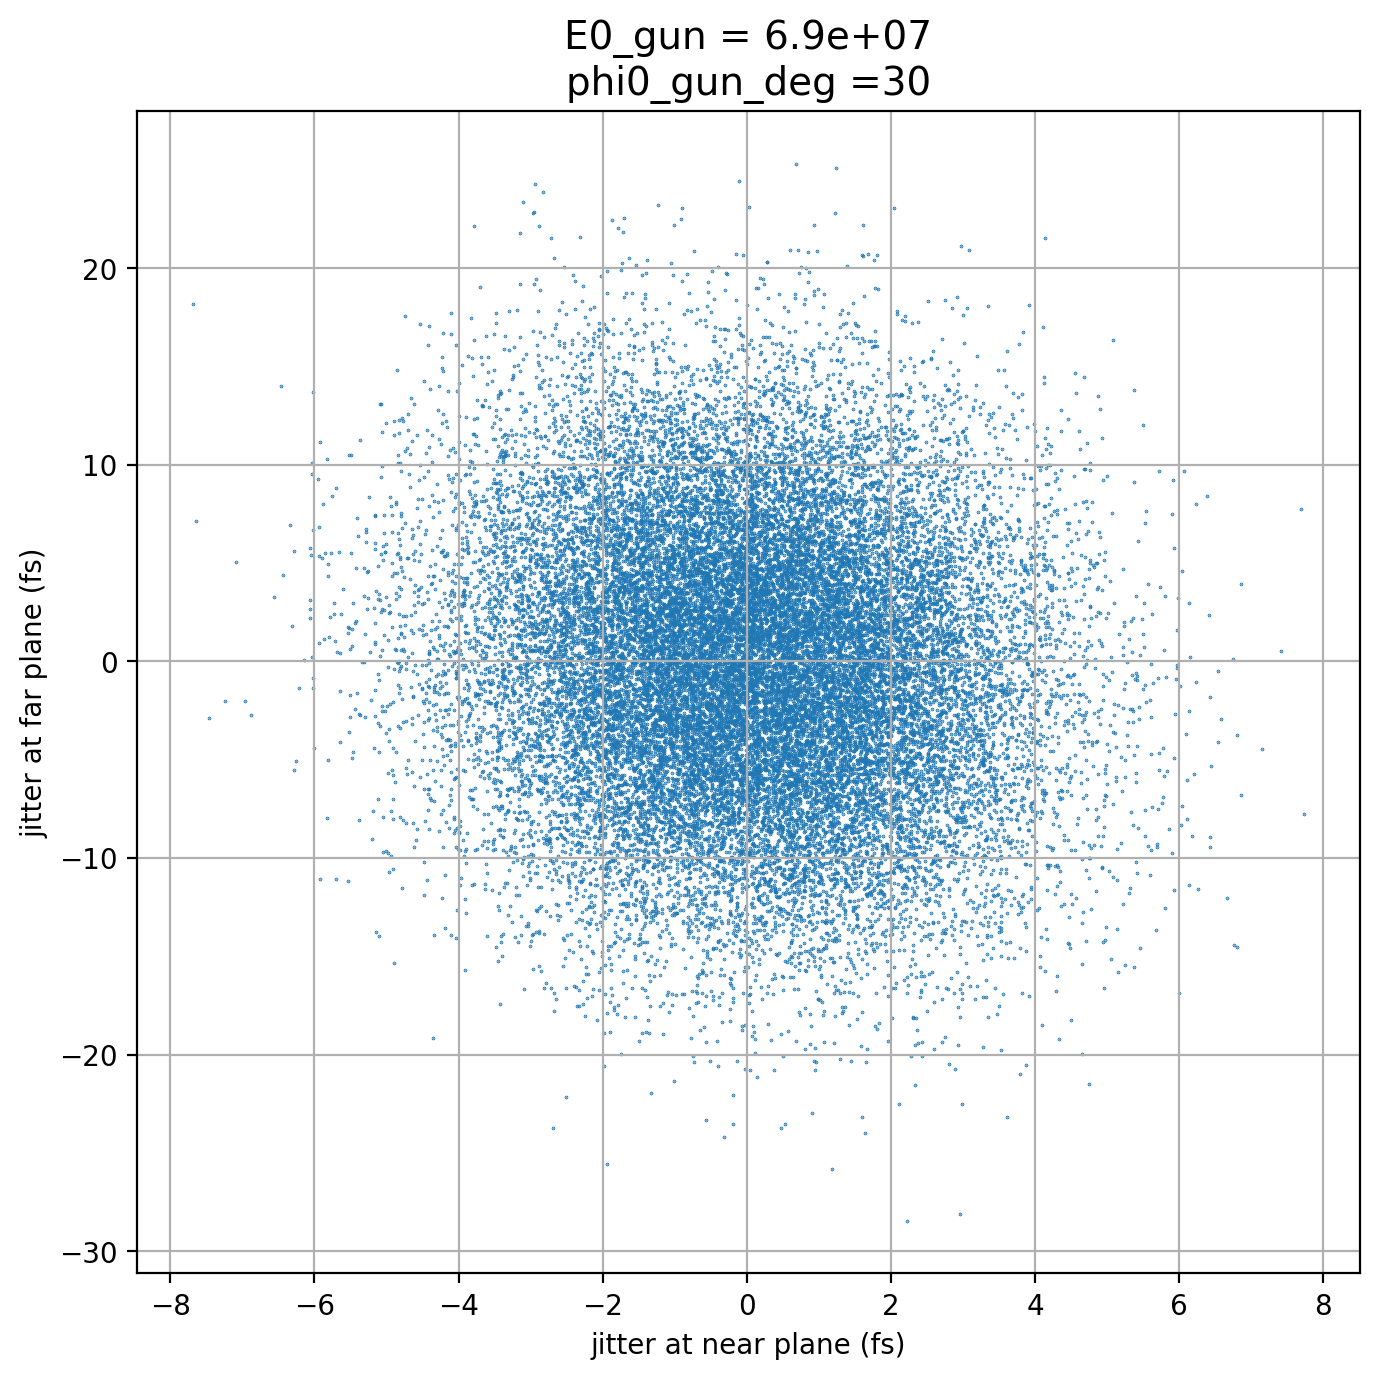

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(ts_near*1e15, ts_far*1e15, s=0.1)

# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)

ax.set_xlabel("jitter at near plane (fs)")
ax.set_ylabel("jitter at far plane (fs)")
ax.set_title(f"{E0_gun = :.1e}\n{phi0_gun_deg =}",fontsize=14)
ax.grid()

# ax.set_box_aspect(1)
# ax.axis('equal')
# ax.legend()
fig.tight_layout()
plt.show()

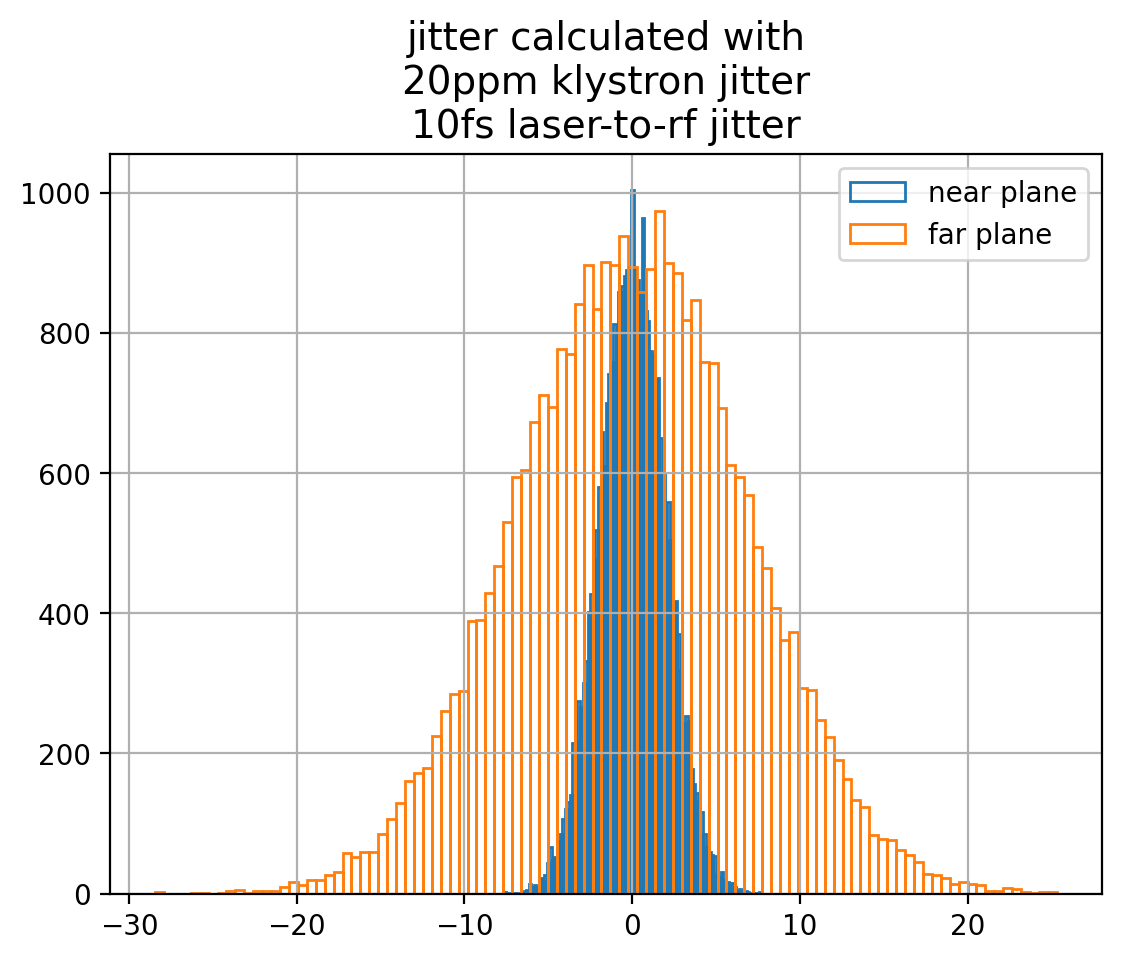

In [12]:
fig, ax = plt.subplots()
ax.hist(ts_near*1e15,101,facecolor='none',edgecolor='C0',label='near plane');
ax.hist(ts_far*1e15 ,101,facecolor='none',edgecolor='C1',label='far plane');
ax.set_title(f'jitter calculated with\n{klystron_jitter_frac_rms/1e-6:.0f}ppm klystron jitter\n{phase_jitter_sync_rms/2/np.pi/f/1e-15:.0f}fs laser-to-rf jitter',fontsize=14)
ax.grid()
ax.legend()
plt.show()

In [13]:
gamma_f, toa_tot = get_coefs(phi0_gun_deg, E0_gun, 1.557, return_jitter_only=False)

  0%|          | 0/2601 [00:00<?, ?it/s]

In [14]:
gamma_f, toa_tot

(-0.564059*dφ1+7.21973+6.06638*dα1, -1.09696e-11*dφ1-1.08766e-10*dα1)

In [15]:
C1_gamma = gamma_f.find_cf([1,0])
C2_gamma = gamma_f.find_cf([0,1])

C1_toa   = toa_tot.find_cf([1,0])
C2_toa   = toa_tot.find_cf([0,1])

print(f"{C1_gamma = }")
print(f"{C2_gamma = }")
print(f"{C1_toa = }")
print(f"{C2_toa = }")

C1_gamma = 6.066379120832561

C2_gamma = -0.5640593983667412

C1_toa = -1.0876584618206127e-10

C2_toa = -1.0969579557111934e-11

In [16]:
gamma_sample         = C1_gamma * alpha_nominal * amplitude_jitter_frac + C2_gamma * phase_jitter_eff
ts_sample            = C1_toa   * alpha_nominal * amplitude_jitter_frac +  C2_toa  * phase_jitter_eff

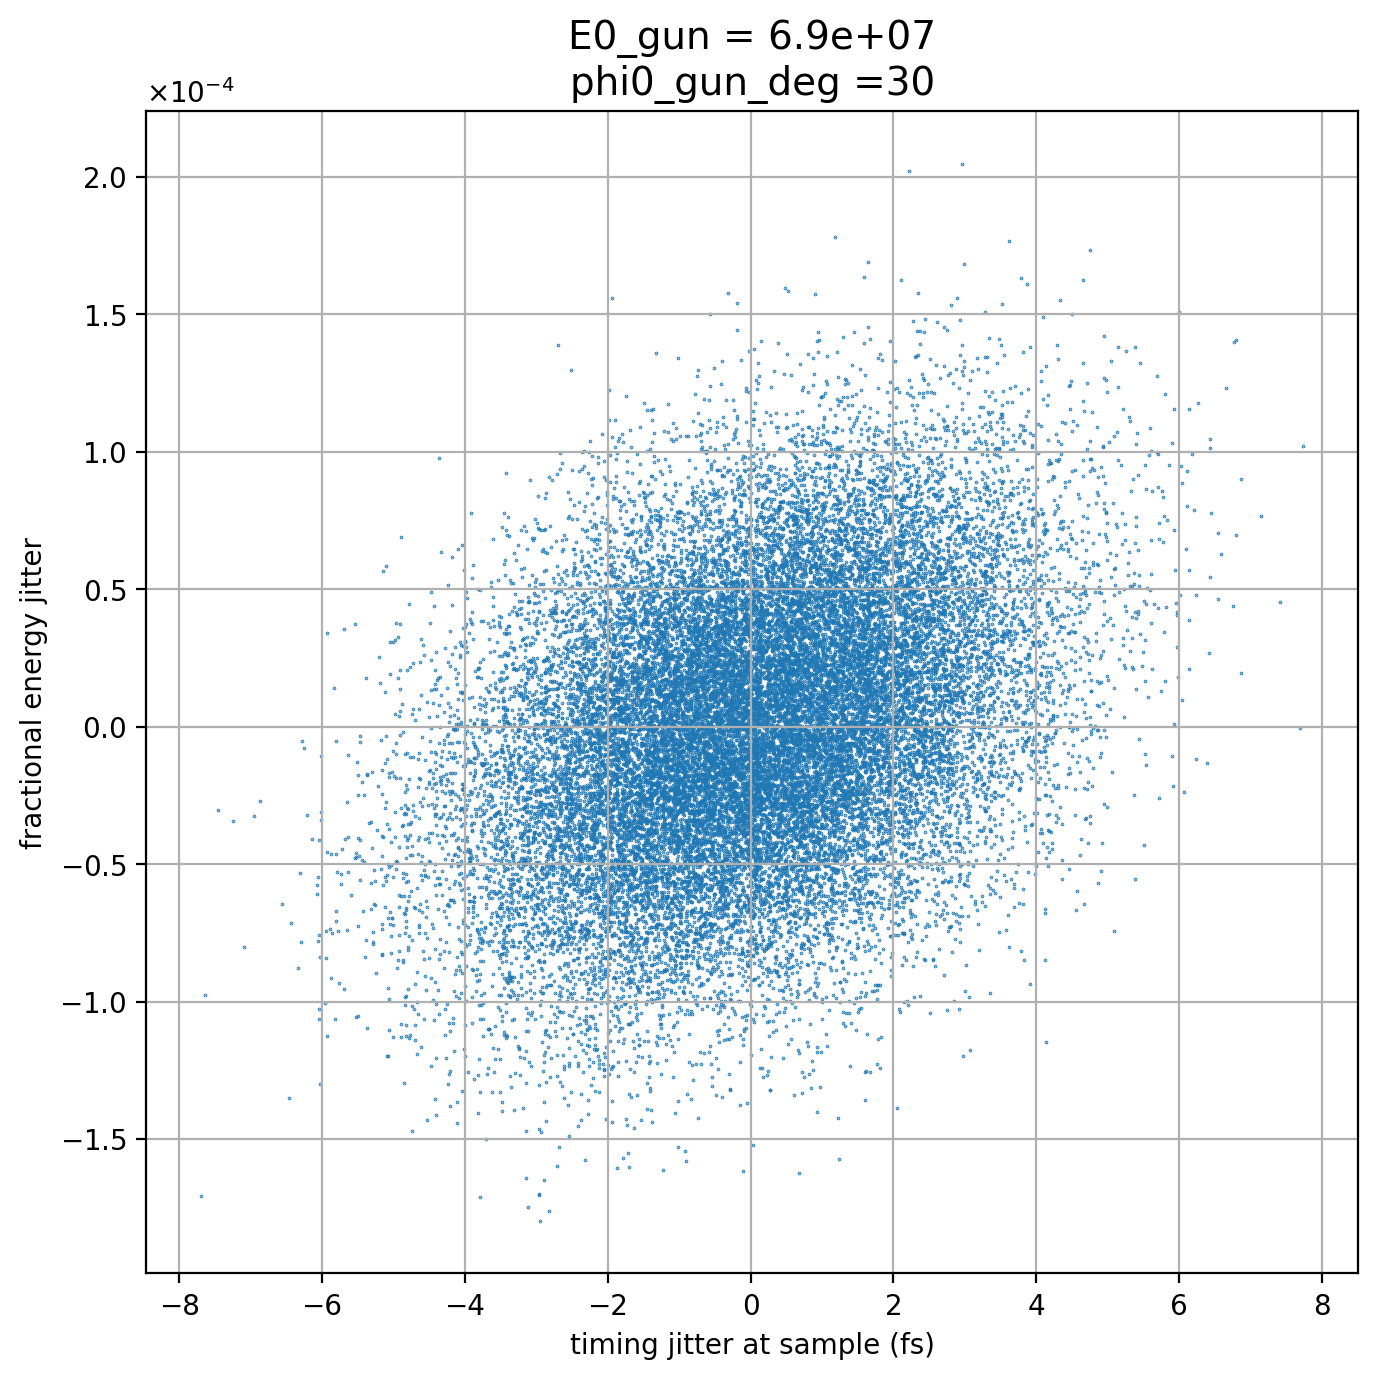

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(ts_sample*1e15, gamma_sample/gamma_f.constant_cf, s=0.1)

# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)

ax.set_xlabel("timing jitter at sample (fs)")
ax.set_ylabel("fractional energy jitter")
ax.ticklabel_format(axis='y',style='sci', scilimits=(-1,1),useMathText=True)

ax.set_title(f"{E0_gun = :.1e}\n{phi0_gun_deg =}",fontsize=14)
ax.grid()

# ax.set_box_aspect(1)
# ax.axis('equal')
# ax.legend()
fig.tight_layout()
plt.show()

In [18]:
np.polyfit(gamma_sample/gamma_f.constant_cf, -ts_sample*c, 1)

array([-4.48818102e-03, -6.74795768e-09])